# Twitter Scraping

In [1]:
import tweepy
import json
import time
import numpy as np

In [2]:
# # save twitter data, do not need to run
# consumer_key = '********'
# consumer_secret = '********'
# access_token = '********'
# access_token_secret = '********'
# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_token_secret)

# api = tweepy.API(auth, wait_on_rate_limit=True)
# public_tweets_list = []
# for i in range(100):
#     public_tweets_100 = api.search(q='covid', result_type='recent', count = 100, lang='en', tweet_mode="extended")
#     public_tweets_list.append(public_tweets_100)

# with open("tweets_all.json", "w") as fout:  
#     for tweets_100 in public_tweets_list:
#         for tweet in tweets_100:
#             json.dump(tweet._json, fout) 
#             fout.write('\n')

In [3]:
tweets_all = []
with open("tweets_all.json") as f:  
    for line in f:
        js = json.loads(line)
        tweets_all.append(js)

In [4]:
tweet_content = []
for tweet in tweets_all:
    if 'retweeted_status' in tweet.keys():
        content = tweet['retweeted_status']['full_text']
    else:
        content = tweet['full_text']
    tweet_content.append(content)
print("Tweets number: {}".format(len(tweet_content)))

Tweets number: 10000


In [5]:
tweet_content[:5]

['@SanjayM33162682 @QL1wBZCUsCudbqm Very great !🤩\nI definitely want to go to India when COVID-19 is over.😊',
 'Malaysia Aviation Group (MAG) cargo subsidiary MABkargo successfully flew in the first batch of COVID-19 vaccine to Malaysia today in close collaboration with the Ministry of Science, Technology &amp; Innovation, Ministry of Transport, Ministry of Health, Pfizer and DHL Express. https://t.co/hGTLHg64SJ',
 'Post Covid,i do not see any Zim employee working remotely;\n1.The digital infrastructure is not reliable.\n2.Employees love the office\n3.Employers (managers) want to see people physically at work to feel powerful.   \n4.Home environments not suitable for WFH.\n#hrperspective',
 "Virtually every aspect of the COVID vaccine, from the lipid nanoparticles to the mRNA technology, was developed in academic labs using public funds. But in the public's mind the credit goes to companies like Moderna/Pfizer. This is a missed opportunity to celebrate basic research",
 'Australian Pri

## Pre-processing tweets

In [6]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

In [7]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [8]:
def process_tweet_for_LM(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        res: a list of sentences containing the processed tweet

    """
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove emoji
    tweet = re.sub(r'[\U00010000-\U0010ffff]', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # tokenize tweets
    sentences = nltk.sent_tokenize(tweet)
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)
    res = []
    for sentence in sentences:
        tweet_tokens = tokenizer.tokenize(sentence)
        if len(tweet_tokens)>0:
            res.append(tweet_tokens)

    return res

In [9]:
twitter_train_sentences = []
for text in tweet_content[:9000]:
    sents = process_tweet_for_LM(text)
    twitter_train_sentences.extend(sents)
twitter_test_sentences = []
for text in tweet_content[9000:]:
    sents = process_tweet_for_LM(text)
    twitter_test_sentences.extend(sents)
print('Tweets train senteces number: {}'.format(len(twitter_train_sentences)))
print('Tweets test senteces number: {}'.format(len(twitter_test_sentences)))

Tweets train senteces number: 19576
Tweets test senteces number: 2168


## Language model for twitter

In [13]:
from nltk.lm.models import KneserNeyInterpolated
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten

In [14]:
def traim_lm_model(N_GRAM, train_sentences):
    train_data, padded_sents = padded_everygram_pipeline(N_GRAM, train_sentences)
    model = KneserNeyInterpolated(N_GRAM) # Lets train a n-grams model, previously we set n=1,2,3
    model.fit(train_data, padded_sents)
    print("Ngram model: {}".format(model.vocab))
    return model

In [15]:
UNI_GRM = 1
BI_GRM = 2
TRI_GRM = 3
uni_model = traim_lm_model(UNI_GRM, twitter_train_sentences)
bi_model = traim_lm_model(BI_GRM, twitter_train_sentences)
tri_model = traim_lm_model(TRI_GRM, twitter_train_sentences)

Unigram model: <Vocabulary with cutoff=1 unk_label='<UNK>' and 15032 items>
Unigram model: <Vocabulary with cutoff=1 unk_label='<UNK>' and 15034 items>
Unigram model: <Vocabulary with cutoff=1 unk_label='<UNK>' and 15034 items>


In [16]:
def test_lm_model(model, N_GRAM, test_sentences):
    test_data, padded_sents_test = padded_everygram_pipeline(N_GRAM, test_sentences)
    ngram_perplex = []
    n = 0
    for ngramlize_sent in test_data:
        ngram_list = list(ngramlize_sent)
        ngram_sent = []
        for ngram in ngram_list:
            if len(ngram) == N_GRAM:
                ngram_sent.append(ngram)
        ngram_perplex.append(model.perplexity(ngram_sent))
#         n += 1
#         if n % 200 == 0:
#             print("Processing: {}".format(n))
    perplex = np.mean(ngram_perplex)
    return perplex

In [17]:
uni_perplex = test_lm_model(uni_model, UNI_GRM, twitter_test_sentences)
bi_perplex  = test_lm_model(bi_model,  BI_GRM,  twitter_test_sentences)
tri_perplex = test_lm_model(tri_model, TRI_GRM, twitter_test_sentences)

In [18]:
print("Unigram perplex: {}".format(uni_perplex))
print("Bigram perplex: {}".format(bi_perplex))
print("Trigram perplex: {}".format(tri_perplex))

Unigram perplex: 15032.00000000002
Bigram perplex: 3403.780819382352
Trigram perplex: 2426.9137807048805


## Generate tweets

In [22]:
from nltk.lm.models import MLE
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [20]:
def train_lm_model_for_generate(N_GRAM, train_sentences):
    train_data, padded_sents = padded_everygram_pipeline(N_GRAM, train_sentences)
    model = MLE(N_GRAM) # Lets train a n-grams model, previously we set n=1,2,3
    model.fit(train_data, padded_sents)
    print("Ngram model: {}".format(model.vocab))
    return model

In [21]:
uni_model = train_lm_model_for_generate(UNI_GRM, twitter_train_sentences)
bi_model = train_lm_model_for_generate(BI_GRM, twitter_train_sentences)
tri_model = train_lm_model_for_generate(TRI_GRM, twitter_train_sentences)

Ngram model: <Vocabulary with cutoff=1 unk_label='<UNK>' and 15032 items>
Ngram model: <Vocabulary with cutoff=1 unk_label='<UNK>' and 15034 items>
Ngram model: <Vocabulary with cutoff=1 unk_label='<UNK>' and 15034 items>


In [37]:
def generate_sent(model, num_words, random_seed=42):
    """
    :param model: An ngram language model from `nltk.lm.model`.
    :param num_words: Max no. of words to generate.
    :param random_seed: Seed value for random.
    """
    detokenize = TreebankWordDetokenizer().detokenize
    content = []
    for token in model.generate(num_words):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenize(content)

In [38]:
unigram_generate_tweets = []
bigram_generate_tweets = []
trigram_generate_tweets = []

for i in range(10):
    unigram_generate_tweets.append(generate_sent(uni_model, 20))
    bigram_generate_tweets.append(generate_sent(bi_model, 20))
    trigram_generate_tweets.append(generate_sent(tri_model, 20))

In [39]:
unigram_generate_tweets[:5]

['’ work aur the to show mind intel we gift to one without visitors for of the he the out',
 'killarney deaths with 19 & position are covid to touched crises away have good isolation: help vax hiv az',
 'private jab distancing being a covid today the that the have k1 has and better sorry covid blah lockdown the',
 's his back debt +0.20 inoculated he sad importance reassuring coronavirus the johnson anxiety 19 scotland covid been! show',
 '" y " ., just ” actor i this scathing is much 25 years unlawfully during - jamaluddin geocaching']

In [40]:
bigram_generate_tweets[:5]

['relief for a debutante party, you ’ in the reopenschools date, was an epidemiologist, work with covid',
 ': only 1.3% for the answer is opportunity during initial shutdown.',
 'their own pet projects / o who calls for you are relatively) throughout this covid and clinics for covid',
 'what else.',
 'in a covid vaccinees nears 500,000 deaths.']

In [41]:
trigram_generate_tweets[:5]

['go out anymore orrr no one gives a fuck.',
 'of universal deceit, telling the truth becomes a revolutionary act.',
 '’ re always with you, hero.',
 "one of hundreds of millions of syrians while they would be included in the' raw' ingredients growing since",
 'plane and caught covid - 19.']

In [43]:
with open('generate_tweets.txt', 'w') as f:
    for tweets in unigram_generate_tweets+bigram_generate_tweets+trigram_generate_tweets:
        f.write("{}\n".format(tweets))

## Twitter sentiment analysis

In [45]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [46]:
senti_analyzer = SentimentIntensityAnalyzer()

In [53]:
compound_score = []
num_postive = 0
num_neutral = 0
num_negative = 0
pos_twitter = []
neu_twitter = []
neg_twitter = []
for text in tweet_content:
    sentiment = senti_analyzer.polarity_scores(text)
    score = sentiment['compound']
    compound_score.append(score)
    if score >= 0.05:
        num_postive += 1
        pos_twitter.append(text)
    elif score < 0.05 and score > -0.05:
        num_neutral += 1
        neu_twitter.append(text)
    elif score <= -0.05:
        num_negative += 1
        neg_twitter.append(text)
    else:
        print("no match!!")
print("pos: {}  neu: {}  neg: {}".format(num_postive,num_neutral,num_negative))

pos: 4292  neu: 2008  neg: 3700


In [55]:
print("Average compound score: {}".format(np.mean(compound_score)))

Average compound score: 0.0371882


In [58]:
print("Number of positive tweets: {}".format(len(pos_twitter)))

Number of positive tweets: 4292


## Top-10 words of postive/negtive tweets

In [59]:
from collections import Counter

In [60]:
def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    lemmatizer = WordNetLemmatizer()  
    stopwords_english = nlp.Defaults.stop_words
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove emoji
    tweet = re.sub(r'[\U00010000-\U0010ffff]', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        # remove stopwords, remove punctuation
        if word not in stopwords_english and word not in string.punctuation:
            if len(word) > 1 and re.search('[a-zA-Z]',word):
                lem_word = lemmatizer.lemmatize(word) 
                tweets_clean.append(lem_word)

    return tweets_clean

In [61]:
pos_words = []
for tweet in pos_twitter:
    tweet_clean = process_tweet(tweet)
    pos_words.extend(tweet_clean)
pos_counts = Counter(pos_words)

In [62]:
pos_counts.most_common(10)

[('covid', 4088),
 ('vaccine', 869),
 ('pandemic', 439),
 ('like', 394),
 ('people', 352),
 ('time', 345),
 ('lost', 310),
 ('help', 304),
 ('today', 290),
 ('contract', 277)]

In [63]:
neg_words = []
for tweet in neg_twitter:
    tweet_clean = process_tweet(tweet)
    neg_words.extend(tweet_clean)
neg_counts = Counter(neg_words)

In [64]:
neg_counts.most_common(10)

[('covid', 3626),
 ('people', 608),
 ('death', 574),
 ('vaccine', 507),
 ('new', 358),
 ('died', 342),
 ('day', 328),
 ('time', 323),
 ('news', 323),
 ('health', 308)]

## Bonus

In [145]:
tweets_all[0].keys()

dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'metadata', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'lang'])

In [216]:
tweet_content_place = []
for tweet in tweets_all:
    if tweet['place'] != None:
        info = {}
        if 'retweeted_status' in tweet.keys():
            content = tweet['retweeted_status']['full_text']
        else:
            info['full_text'] = tweet['full_text']
        info['place'] = tweet['place']['full_name']
        tweet_content_place.append(info)
print("Number of Tweets contain place: {}".format(len(tweet_content_place)))

Number of Tweets contain place: 78


In [217]:
place_score = {}
for info in tweet_content_place:
    text = info['full_text']
    place = info['place'].split(', ')[-1]
    sentiment = senti_analyzer.polarity_scores(text)
    score = sentiment['compound']
    if place not in place_score:
        place_score[place] = []
        place_score[place].append(score)
    else:
        place_score[place].append(score)
for k,v in place_score.items():
    place_score[k] = np.mean(v)

In [218]:
place_score_order=sorted(place_score.items(), key=lambda x:x[1], reverse=True)

In [219]:
place_score_order[:10]

[('United Arab Emirates', 0.9866),
 ('Scotland', 0.9222),
 ('New Zealand', 0.8176),
 ('FL', 0.7757),
 ('CO', 0.68885),
 ('Maldives', 0.6733),
 ('USA', 0.6249),
 ('Hong Kong', 0.5106),
 ('London', 0.4063),
 ('Bangladesh', 0.4019)]

In [220]:
place_score_order[-10:]

[('Sardegna', -0.1803),
 ('TX', -0.1854),
 ('Victoria', -0.307725),
 ('CA', -0.34515),
 ('Nederland', -0.4019),
 ('Ireland', -0.4939),
 ('HI', -0.5719),
 ('KY', -0.5849),
 ('South East', -0.5994),
 ('Australian Capital Territory', -0.8422)]

# Wikipedia Scraping

In [65]:
import requests
import re
import json
from bs4 import BeautifulSoup

In [76]:
# # save wiki data, do not need to run

# wiki_url = 'https://en.wikipedia.org/wiki/COVID-19_pandemic'
# result = requests.get(wiki_url)
# first_page = result.text

# soup = BeautifulSoup(first_page, 'html.parser')
# fist_content = soup.find(id='mw-content-text')
# listUrl = fist_content.findAll("a",href=re.compile("^/wiki/"))

# listUrl_clean = []
# for link in listUrl[:]:
#     if not re.search('Help:|File:|Wikipedia:|Portal:|Template:|Category:|Template_talk|Special|Book:',link.get("href")):
#         listUrl_clean.append('https://en.wikipedia.org'+link.get('href'))
# listUrl_clean = list(set(listUrl_clean))
# listUrl_clean.insert(0,wiki_url)

# wiki_content = []
# for url in listUrl_clean:
#     r = requests.get(url)
#     html_doc = r.text
#     soup = BeautifulSoup(html_doc, 'html.parser')
#     para = soup.find_all('p')
#     article = []
#     for p in para:
#         if (p.has_attr('class') and ('mw-empty-elt' in p['class'])):
#             continue
#         article.append(p.get_text())
#     wiki_content.append(article)
    
# with open('wiki_data.txt','w') as fout:
#     for article in wiki_content:
#         for content in article:
#             fout.write(content)

In [82]:
wiki_text = []
with open('wiki_data.txt') as f:
    for line in f:
        line = line.replace('\xa0',' ').replace('\ufeff',' ') #用replace替换掉'\xa0'
        wiki_text.append(line.strip())
print(len(wiki_text))

102777


In [83]:
import nltk
from nltk.stem import WordNetLemmatizer  
import string
import spacy
nlp = spacy.load('en_core_web_sm')

In [84]:
def process_wiki_data(text):
    lemmatizer = WordNetLemmatizer()  
    stopwords_english = nlp.Defaults.stop_words
    text = re.sub(r'\[\d*\]', ' ', text)
    text = re.sub(r'‡', '', text)
    sentences = nltk.sent_tokenize(text)
    res = []
    for sentence in sentences: #Sentence split
        text_tokens = nltk.word_tokenize(sentence) # tokenize
        text_clean = []
        for word in text_tokens:
            word = word.lower() # lowercases
            if word not in stopwords_english and word not in string.punctuation: # remove stopwords, remove punctuation
                if len(word) > 1 and re.search('[a-zA-Z]',word):
                    lem_word = lemmatizer.lemmatize(word) # lemmatize
                    text_clean.append(lem_word)
        if len(text_clean)>0:
            res.append(text_clean)

    return res

In [85]:
wiki_sentences = []
for text in wiki_text:
    sents = process_wiki_data(text)
    wiki_sentences.extend(sents)
print("Number wiki sentences: {}".format(len(wiki_sentences)))

Number wiki sentences: 263358


In [86]:
wiki_words = []
for sent in wiki_sentences:
    wiki_words.extend(sent)
print("Number wiki words: {}".format(len(wiki_words)))

Number wiki words: 3116212


## Top-20 wiki words

In [87]:
import collections
from collections import Counter

In [88]:
wiki_vocab = Counter(wiki_words)
print("Wiki vocab size: {}".format(len(wiki_vocab)))
wiki_vocab.most_common(20)

Wiki vocab size: 102789


[('case', 40072),
 ('state', 22205),
 ('new', 21705),
 ('march', 19512),
 ('covid-19', 18097),
 ('health', 16044),
 ('confirmed', 15400),
 ('people', 15080),
 ('government', 14769),
 ('day', 13505),
 ('number', 13025),
 ('death', 12902),
 ('country', 12825),
 ('announced', 12770),
 ('april', 12238),
 ('total', 11901),
 ('reported', 11124),
 ('pandemic', 10785),
 ('virus', 9245),
 ('city', 8999)]

In [89]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [90]:
def make_wordcloud(text, picture_name):
    wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    wordcloud.to_file(picture_name)

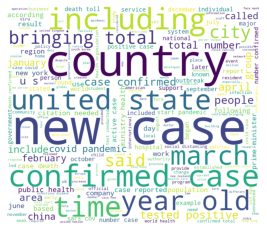

In [75]:
make_wordcloud(" ".join(wiki_words), 'wikipedia_covid.png')

## Use wikipedia as vocab

In [91]:
twitter_test_words = []
for text in tweet_content[9000:]:
    tweets_clean = process_tweet(text)
    twitter_test_words.extend(tweets_clean)
print("twitter test set token size: {}".format(len(twitter_test_words)))

twitter test set token size: 15569


In [92]:
twitter_test_vocab = Counter(twitter_test_words)
print("twitter test set vocab size: {}".format(len(twitter_test_vocab)))

twitter test set vocab size: 3980


In [93]:
num_oov_type = 0
for word in twitter_test_vocab:
    if word not in wiki_vocab:
        num_oov_type += 1
print("Word type OOV-rate: {}".format(num_oov_type/len(twitter_test_vocab)))

Word type OOV-rate: 0.13542713567839196


In [94]:
num_oov_token = 0
for word in twitter_test_words:
    if word not in wiki_vocab:
        num_oov_token += 1
print("Word token OOV-rate: {}".format(num_oov_type/len(twitter_test_words)))

Word token OOV-rate: 0.03462007836084527


## Use twitter training set as vocab

In [159]:
twitter_train_words = []
for text in tweet_content[:9000]:
    tweets_clean = process_tweet(text)
    twitter_train_words.extend(tweets_clean)
print("twitter trian set token length: {}".format(len(twitter_train_words)))

twitter trian set token length: 136754


In [160]:
twitter_train_vocab = Counter(twitter_train_words)
print("twitter test set vocab length: {}".format(len(twitter_train_vocab)))

twitter test set vocab length: 12682


In [164]:
num_oov_type = 0
for word in twitter_test_vocab:
    if word not in twitter_train_vocab:
        num_oov_type += 1
print("Word type OOV-rate: {}".format(num_oov_type/len(twitter_test_vocab)))

Word type OOV-rate: 0.16432160804020102


In [162]:
num_oov_token = 0
for word in twitter_test_words:
    if word not in twitter_train_vocab:
        num_oov_token += 1
print("Word token OOV-rate: {}".format(num_oov_type/len(twitter_test_words)))

Word token OOV-rate: 0.04200655148050613


## wiki language model

In [95]:
def process_wiki_for_LM(text):
    lemmatizer = WordNetLemmatizer()  
    stopwords_english = nlp.Defaults.stop_words
    text = re.sub(r'\[\d*\]', ' ', text)
    text = re.sub(r'‡', '', text)
    sentences = nltk.sent_tokenize(text)
    res = []
    for sentence in sentences:
        sentence = sentence.lower()
        text_tokens = nltk.word_tokenize(sentence) # tokenize
        if len(text_tokens)>0:
            res.append(text_tokens)

    return res

In [101]:
wiki_train_sentences = []
for text in wiki_text:
    sents = process_wiki_for_LM(text)
    wiki_train_sentences.extend(sents)
    if len(wiki_train_sentences) >= 9000:
        break
print("Number of wiki train sentences: {}".format(len(wiki_train_sentences)))

Number of wiki train sentences: 9000


In [113]:
tri_model_wiki = traim_lm_model(TRI_GRM, wiki_train_sentences)

Ngram model: <Vocabulary with cutoff=1 unk_label='<UNK>' and 18117 items>


In [116]:
tri_perplex_wiki = test_lm_model(tri_model_wiki, TRI_GRM, twitter_test_sentences)

In [117]:
print("Trigram perplex for wiki: {}".format(tri_perplex_wiki))

Trigram perplex for wiki: 15517.037158104928


# News Scraping

In [120]:
fox_text = []
with open('fox_news.jsonl') as f:
    for line in f:
        js = json.loads(line)
        fox_text.append(js['bodytext'])
print("Number of Fox news artivle: {}".format(len(fox_text)))

Number of Fox news artivle: 500


In [121]:
abc_text = []
with open('abc_news.jsonl') as f:
    for line in f:
        js = json.loads(line)
        abc_text.append(js['bodytext'])
print("Number of ABC news artivle: {}".format(len(abc_text)))

Number of ABC news artivle: 106


In [122]:
def process_news_data(text):
    lemmatizer = WordNetLemmatizer()  
    stopwords_english = nlp.Defaults.stop_words
    text = re.sub(r'close Video ', ' ', text)
    sentences = nltk.sent_tokenize(text)
    res = []
    for sentence in sentences: #Sentence split
        text_tokens = nltk.word_tokenize(sentence) # tokenize
        text_clean = []
        for word in text_tokens:
            word = word.lower() # lowercases
            word = re.sub(r'\'', '', word)
            if word not in stopwords_english and word not in string.punctuation: # remove stopwords, remove punctuation
                if len(word) > 1 and re.search('[a-zA-Z]',word):
                    lem_word = lemmatizer.lemmatize(word) # lemmatize
                    text_clean.append(lem_word)
        if len(text_clean)>0:
            res.append(text_clean)

    return res

In [123]:
fox_sentences = []
for text in fox_text:
    fox_sentences.extend(process_news_data(text))
print("Number of Fox news sentences: {}".format(len(fox_sentences)))

Number of Fox news sentences: 15983


In [124]:
abc_sentences = []
for text in abc_text:
    abc_sentences.extend(process_news_data(text))
print("Number of ABC news sentences: {}".format(len(abc_sentences)))

Number of ABC news sentences: 3353


In [131]:
def make_type_token_graph(news_sentences, news_name):
    type_count = 0
    token_count = 0
    num_type = []
    num_token = []
    type_set = set()
    for sent in news_sentences:
        for word in sent:
            token_count += 1
            if word not in type_set:
                type_set.add(word)
                type_count += 1
            num_type.append(type_count)
            num_token.append(token_count)
    title_name = "{} news type-word token graph".format(news_name)
    plt.title(title_name) 
    plt.xlabel("#token") 
    plt.ylabel("#type") 
    plt.plot(num_token,num_type)
    plt.savefig("{}.png".format(title_name))
    plt.show()

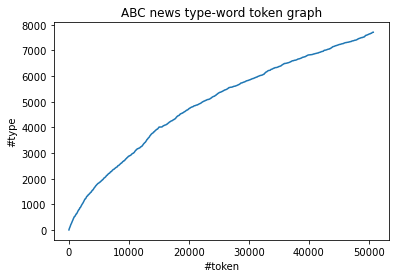

In [132]:
make_type_token_graph(abc_sentences, 'ABC')

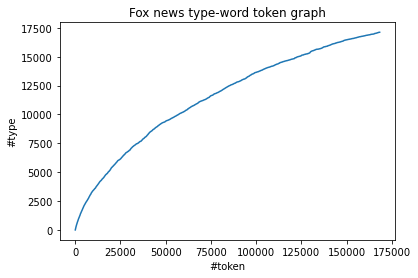

In [133]:
make_type_token_graph(fox_sentences, 'Fox')

## News wordcloud

In [136]:
abc_words = []
for sent in abc_sentences:
    for word in sent:
        if (word!='pm' and word!='nt'):
            abc_words.append(word)

In [139]:
fox_words = []
for sent in fox_sentences:
    for word in sent:
        fox_words.append(word)

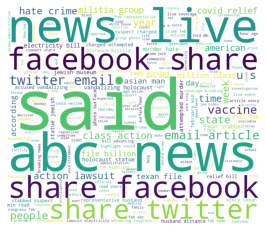

In [140]:
make_wordcloud(" ".join(abc_words), 'abc_news.png')

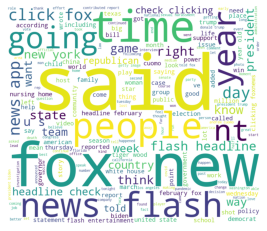

In [141]:
make_wordcloud(" ".join(fox_words), 'fox_news.png')